In [ ]:
!unzip "images_dl.zip"

Archive:  images_dl.zip
   creating: images_dl/
  inflating: images_dl/000001.jpg    
  inflating: images_dl/000002.jpg    
  inflating: images_dl/000003.jpg    
  inflating: images_dl/000004.jpg    
  inflating: images_dl/000005.jpg    
  inflating: images_dl/000006.jpg    
  inflating: images_dl/000007.jpg    
  inflating: images_dl/000008.jpg    
  inflating: images_dl/000009.jpg    
  inflating: images_dl/000010.jpg    
  inflating: images_dl/000011.jpg    
  inflating: images_dl/000012.jpg    
  inflating: images_dl/000013.jpg    
  inflating: images_dl/000014.jpg    
  inflating: images_dl/000015.jpg    
  inflating: images_dl/000016.jpg    
  inflating: images_dl/000017.jpg    
  inflating: images_dl/000018.jpg    
  inflating: images_dl/000019.jpg    
  inflating: images_dl/000020.jpg    
  inflating: images_dl/000021.jpg    
  inflating: images_dl/000022.jpg    
  inflating: images_dl/000023.jpg    
  inflating: images_dl/000024.jpg    
  inflating: images_dl/000025.jpg    
  

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.utils as vutils
from PIL import Image
import matplotlib.pyplot as plt

##################################################################################
# Custom Dataset
##################################################################################
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define the transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = CustomImageDataset('/content/images_dl', transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

##################################################################################
# Utility Functions
##################################################################################

def detect_edges(images, threshold1=100, threshold2=200):
    """Convert batch of images to edges using Canny edge detector"""
    # Denormalize images from [-1, 1] to [0, 255]
    images_np = ((images.permute(0, 2, 3, 1).cpu().numpy() + 1) * 127.5).astype(np.uint8)
    edges = []
    for i in range(images_np.shape[0]):
        # Convert to grayscale if needed
        if images_np.shape[3] == 3:
            gray = cv2.cvtColor(images_np[i], cv2.COLOR_RGB2GRAY)
        else:
            gray = images_np[i]
        edge = cv2.Canny(gray, threshold1, threshold2)
        edge = torch.from_numpy(edge).float() / 255.0
        edge = edge.unsqueeze(0)  # [1, H, W]
        edges.append(edge)
    edges = torch.stack(edges, dim=0)  # [B, 1, H, W]
    return edges

def to_grayscale(images):
    """Convert batch of RGB images to grayscale. [B, 3, H, W] -> [B, 1, H, W]"""
    gray = 0.299 * images[:, 0:1, :, :] + 0.587 * images[:, 1:2, :, :] + 0.114 * images[:, 2:3, :, :]
    return gray

def apply_mask(images, mask_size=50):
    device = images.device
    masked_images = images.clone()
    masks = torch.ones_like(images)
    batch_size = images.shape[0]
    for i in range(batch_size):
        x = np.random.randint(0, images.shape[2] - mask_size)
        y = np.random.randint(0, images.shape[3] - mask_size)
        masked_images[i, :, x:x+mask_size, y:y+mask_size] = 0
        masks[i, :, x:x+mask_size, y:y+mask_size] = 0
    return masked_images, masks


#contetxual attention
class ContextualAttention(nn.Module):
    def __init__(self, kernel_size=3, stride=1, rate=2, fuse_k=3, softmax_scale=10.0, fuse=True):
        super(ContextualAttention, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.rate = rate
        self.fuse_k = fuse_k
        self.softmax_scale = softmax_scale
        self.fuse = fuse

        # Create fuse kernel - we'll create it on the fly in forward pass instead of storing as parameter
        self.fuse = fuse

    def forward(self, f, b, mask=None):
        """
        f: feature map with holes to be filled (foreground)
        b: background feature map used to fill the holes
        mask: binary mask indicating holes (0) and valid regions (1)
        """
        batch_size, channels, h, f_h, f_w = f.size(0), f.size(1), f.size(2), f.size(2), f.size(3)
        b_h, b_w = b.size(2), b.size(3)

        # Handle dilation rate by downsampling if rate > 1
        if self.rate > 1:
            # Downsample f
            f_down = F.interpolate(f, scale_factor=1.0/self.rate, mode='nearest')
            b_down = F.interpolate(b, scale_factor=1.0/self.rate, mode='nearest')

            if mask is not None:
                mask_down = F.interpolate(mask, scale_factor=1.0/self.rate, mode='nearest')
            else:
                mask_down = None
        else:
            f_down, b_down, mask_down = f, b, mask

        # Get downsampled dimensions
        f_down_h, f_down_w = f_down.size(2), f_down.size(3)
        b_down_h, b_down_w = b_down.size(2), b_down.size(3)

        # Default mask is all ones (valid everywhere)
        if mask_down is None:
            mask_down = torch.ones_like(f_down)

        # Extract patches from background
        # Using unfold to extract patches
        # Pad the input to handle boundaries
        p = self.kernel_size // 2
        b_pad = F.pad(b_down, [p, p, p, p], mode='reflect')

        # Extract b patches using unfold
        b_patches = F.unfold(b_pad, kernel_size=self.kernel_size, stride=self.stride)
        b_patches = b_patches.view(batch_size, channels, self.kernel_size, self.kernel_size, -1)
        b_patches = b_patches.permute(0, 4, 1, 2, 3)  # [N, H*W, C, k, k]
        num_patches = b_patches.size(1)

        # Create a mask for valid patches
        if mask_down is not None:
            mask_pad = F.pad(mask_down, [p, p, p, p], mode='constant', value=0)
            mask_patches = F.unfold(mask_pad, kernel_size=self.kernel_size, stride=self.stride)
            mask_patches = mask_patches.view(batch_size, -1, self.kernel_size, self.kernel_size, num_patches)
            mask_patches = mask_patches.permute(0, 4, 1, 2, 3)  # [N, H*W, C, k, k]
            # Average the mask values to identify valid patches
            mask_patches = (torch.mean(mask_patches, dim=(2, 3, 4)) > 0.5).float()  # [N, H*W]
        else:
            mask_patches = torch.ones(batch_size, num_patches, device=f.device)

        # Compute patch-wise cosine similarity
        y_list = []
        flow_list = []

        for i in range(batch_size):
            # Normalize the patches for cosine similarity
            b_norms = torch.sqrt(torch.sum(b_patches[i]**2, dim=(1, 2, 3), keepdim=True) + 1e-8)
            b_normalized = b_patches[i] / b_norms

            # Compute similarity scores for each location
            # Reshape f_down for easier convolution
            f_curr = f_down[i:i+1]  # [1, C, H, W]
            y = torch.zeros_like(f_curr)

            # Process each patch and compute similarity
            sim_scores = torch.zeros(1, num_patches, f_down_h, f_down_w, device=f.device)

            # Match patches via correlation
            # Using loop for clearer implementation - can be optimized further
            for patch_idx in range(num_patches):
                if mask_patches[i, patch_idx] > 0.5:  # Only process valid patches
                    # Extract the current patch
                    curr_patch = b_normalized[patch_idx].unsqueeze(0)  # [1, C, k, k]

                    # Compute correlation (equivalent to sliding the patch over f)
                    corr = F.conv2d(f_curr, curr_patch, padding=p)  # [1, 1, H, W]
                    sim_scores[0, patch_idx] = corr.squeeze(1)

            # Apply softmax to get attention weights
            sim_scores = sim_scores * self.softmax_scale

            # Fuse scores to encourage large patches if enabled
            if self.fuse:
                # 1. Reshape scores for fusion
                sim_scores = sim_scores.view(1, num_patches, -1)  # [1, num_patches, H*W]

                # 2. Apply softmax over patches and convert back to image format
                sim_scores = F.softmax(sim_scores, dim=1)
                sim_scores = sim_scores.view(1, num_patches, f_down_h, f_down_w)
            else:
                # Apply softmax along patch dimension without fusing
                sim_scores = sim_scores.view(1, num_patches, -1)
                sim_scores = F.softmax(sim_scores, dim=1)
                sim_scores = sim_scores.view(1, num_patches, f_down_h, f_down_w)

            # Create attention output by weighted sum of patches
            output = torch.zeros_like(f_curr)

            # Get argmax indices for visualization
            _, indices = torch.max(sim_scores.view(1, num_patches, -1), dim=1)

            # Convert indices to 2D locations
            h_indices = torch.div(indices, b_down_w, rounding_mode='floor')
            w_indices = indices % b_down_w
            flow = torch.stack([h_indices, w_indices], dim=-1).float()  # Convert to float here
            flow = flow.view(1, f_down_h, f_down_w, 2)

            # Calculate flow as offset from current position
            h_grid = torch.arange(f_down_h, device=f.device, dtype=torch.float)  # Use float dtype
            h_grid = h_grid.view(1, -1, 1).expand(1, f_down_h, f_down_w)

            w_grid = torch.arange(f_down_w, device=f.device, dtype=torch.float)  # Use float dtype
            w_grid = w_grid.view(1, 1, -1).expand(1, f_down_h, f_down_w)

            flow_vis = flow.clone()
            flow_vis[..., 0] = flow_vis[..., 0] - h_grid
            flow_vis[..., 1] = flow_vis[..., 1] - w_grid

            # Generate the output by patch copying
            # For each location in f, get the best matching patch from b
            for h in range(f_down_h):
                for w in range(f_down_w):
                    # Get the best patch index
                    patch_idx = indices[0, h * f_down_w + w].item()

                    # Get the corresponding patch
                    patch = b_patches[i, patch_idx]  # [C, k, k]

                    # Add the patch to the output at the current location
                    y_h_start = max(0, h - p)
                    y_h_end = min(f_down_h, h + p + 1)
                    y_w_start = max(0, w - p)
                    y_w_end = min(f_down_w, w + p + 1)

                    patch_h_start = max(0, p - h)
                    patch_h_end = self.kernel_size - max(0, h + p + 1 - f_down_h)
                    patch_w_start = max(0, p - w)
                    patch_w_end = self.kernel_size - max(0, w + p + 1 - f_down_w)

                    output[0, :, y_h_start:y_h_end, y_w_start:y_w_end] += patch[:, patch_h_start:patch_h_end, patch_w_start:patch_w_end]

            # Normalize output
            output = output / (self.kernel_size * self.kernel_size)

            # Upsample output to original size if rate > 1
            if self.rate > 1:
                output = F.interpolate(output, size=(f_h, f_w), mode='bilinear', align_corners=False)

                # Create a flow visualization (optional)
                flow_vis = flow_vis.permute(0, 3, 1, 2)  # [1, 2, H, W]

                # Convert flow to RGB image for visualization
                # Simple normalization for visualization
                flow_vis_norm = torch.norm(flow_vis, dim=1, keepdim=True)
                flow_max = torch.max(flow_vis_norm)
                flow_vis = flow_vis / (flow_max + 1e-8)

                # Create an RGB representation
                flow_rgb = torch.zeros(1, 3, f_down_h, f_down_w, device=f.device)
                flow_rgb[:, 0] = torch.abs(flow_vis[:, 0])  # R channel - vertical flow
                flow_rgb[:, 1] = torch.abs(flow_vis[:, 1])  # G channel - horizontal flow

                # Upsample flow visualization
                flow_rgb = F.interpolate(flow_rgb, size=(f_h, f_w), mode='bilinear', align_corners=False)
            else:
                # Just create a dummy flow visualization
                flow_rgb = torch.zeros(1, 3, f_h, f_w, device=f.device)

            y_list.append(output)
            flow_list.append(flow_rgb)

        # Combine batch results
        y = torch.cat(y_list, dim=0)
        flow_vis = torch.cat(flow_list, dim=0)

        return y, flow_vis


class AdaIN(nn.Module):
    def __init__(self, eps: float = 1e-5):
        super().__init__()
        self.eps = eps

    def forward(self, content: torch.Tensor, style: torch.Tensor) -> torch.Tensor:
        # content/style: [B, C, H, W]
        B, C, *_ = content.shape

        # compute per‐channel mean & std
        c_mean = content.view(B, C, -1).mean(dim=2).view(B, C, 1, 1)
        c_std  = content.view(B, C, -1).std(dim=2).view(B, C, 1, 1)  + self.eps

        s_mean = style.view(B, C, -1).mean(dim=2).view(B, C, 1, 1)
        s_std  = style.view(B, C, -1).std(dim=2).view(B, C, 1, 1)  + self.eps

        # normalize content, then apply style stats
        normalized = (content - c_mean) / c_std
        return normalized * s_std + s_mean
##################################################################################
# Partial Convolution and Blocks
##################################################################################
class PartialConv2dMC(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True):
        super(PartialConv2dMC, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, dilation=dilation, bias=bias)
        self.mask_update_area = in_channels * (kernel_size * kernel_size) if isinstance(kernel_size, int) else in_channels * (kernel_size[0] * kernel_size[1])
        kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.weight_mask_updater = torch.ones(out_channels, in_channels, kernel_size[0], kernel_size[1])
        self.weight_mask_updater.requires_grad = False
        nn.init.kaiming_normal_(self.conv.weight)
        if bias:
            nn.init.constant_(self.conv.bias, 0.0)

    def forward(self, input, mask=None):
        device = input.device
        if mask is None:
            mask = torch.ones_like(input)
        weight_mask_updater = self.weight_mask_updater.to(device)
        with torch.no_grad():
            updated_mask = F.conv2d(mask, weight_mask_updater,
                                    stride=self.conv.stride,
                                    padding=self.conv.padding,
                                    dilation=self.conv.dilation)
            mask_ratio = self.mask_update_area / (updated_mask + 1e-8)
            updated_mask = torch.clamp(updated_mask, 0, 1)
            mask_ratio = mask_ratio * updated_mask
        conv_output = self.conv(input * mask)
        return conv_output * mask_ratio, updated_mask

class PCResBlock(nn.Module):
    def __init__(self, channels):
        super(PCResBlock, self).__init__()
        self.conv1 = PartialConv2dMC(channels, channels, kernel_size=3, padding=1)
        self.conv2 = PartialConv2dMC(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, mask):
        residual = x
        out, mask = self.conv1(x, mask)
        out = self.relu(out)
        out, mask = self.conv2(out, mask)
        out = out + residual
        return out, mask

class PCDilatedBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super(PCDilatedBlock, self).__init__()
        self.conv = PartialConv2dMC(in_channels, out_channels, kernel_size=3,
                                    padding=dilation, dilation=dilation)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, mask):
        x, mask = self.conv(x, mask)
        x = self.relu(x)
        return x, mask



##################################################################################
# Edge Generator (G1)
##################################################################################
class EdgeGenerator(nn.Module):
    def __init__(self):
        super(EdgeGenerator, self).__init__()
        # Input: grayscale (1) + masked_edge (1) + mask (1) = 3 channels
        self.enc1 = PartialConv2dMC(3, 64, kernel_size=7, stride=1, padding=3)
        self.enc2 = PartialConv2dMC(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc3 = PartialConv2dMC(128, 256, kernel_size=4, stride=2, padding=1)
        self.dil1 = PCDilatedBlock(256, 256, dilation=2)
        self.dil2 = PCDilatedBlock(256, 256, dilation=4)
        self.dil3 = PCDilatedBlock(256, 256, dilation=8)
        self.dil4 = PCDilatedBlock(256, 256, dilation=16)
        self.res1 = PCResBlock(256)
        self.res2 = PCResBlock(256)
        self.res3 = PCResBlock(256)
        self.res4 = PCResBlock(256)
        self.dec1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.dec2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec3 = nn.Conv2d(64, 1, kernel_size=7, stride=1, padding=3)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, gray, edge, mask):
        # All inputs: [B,1,H,W]
        # Concatenate to get [B, 3, H, W]
        x = torch.cat([gray, edge, mask], dim=1)
        # Replicate mask to 3 channels for propagation
        mask_rep = mask.repeat(1, 3, 1, 1)
        x, mask_rep = self.enc1(x, mask_rep)
        x = self.relu(x)
        x, mask_rep = self.enc2(x, mask_rep)
        x = self.relu(x)
        x, mask_rep = self.enc3(x, mask_rep)
        x = self.relu(x)
        x, mask_rep = self.dil1(x, mask_rep)
        x, mask_rep = self.dil2(x, mask_rep)
        x, mask_rep = self.dil3(x, mask_rep)
        x, mask_rep = self.dil4(x, mask_rep)
        x, mask_rep = self.res1(x, mask_rep)
        x, mask_rep = self.res2(x, mask_rep)
        x, mask_rep = self.res3(x, mask_rep)
        x, mask_rep = self.res4(x, mask_rep)
        x = self.relu(self.dec1(x))
        x = self.relu(self.dec2(x))
        x = self.sigmoid(self.dec3(x))
        return x  # [B,1,H,W]

##################################################################################
# Image Completion Generator (G2)
##################################################################################
class ImageGenerator(nn.Module):
    def __init__(self):
        super(ImageGenerator, self).__init__()
        # Input: RGB image (3) + edge (1) + mask (1) = 5 channels
        self.real_enc1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.real_enc2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.real_enc3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.enc1 = PartialConv2dMC(5, 64, kernel_size=7, stride=1, padding=3)
        self.enc2 = PartialConv2dMC(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc3 = PartialConv2dMC(128, 256, kernel_size=4, stride=2, padding=1)
        self.attn = ContextualAttention(kernel_size=3, stride=1, rate=2, fuse_k=3, softmax_scale=10.0)
        self.dil1 = PCDilatedBlock(256, 256, dilation=2)
        self.dil2 = PCDilatedBlock(256, 256, dilation=4)
        self.dil3 = PCDilatedBlock(256, 256, dilation=8)
        self.dil4 = PCDilatedBlock(256, 256, dilation=16)
        self.res1 = PCResBlock(256)
        self.res2 = PCResBlock(256)
        self.res3 = PCResBlock(256)
        self.res4 = PCResBlock(256)
        self.dec1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.dec2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec3 = nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
        self.adain = AdaIN()

    def forward(self, image, edge, mask,real_images=None):
        # image: [B,3,H,W], edge: [B,1,H,W], mask: [B,3,H,W]
        mask_channel = mask[:, 0:1, :, :]  # [B,1,H,W]
        # Concatenate to get [B, 3+1+1 = 5, H, W]
        x = torch.cat([image, edge, mask_channel], dim=1)
        # Replicate mask_channel to 5 channels for propagation
        mask_rep = mask_channel.repeat(1, 5, 1, 1)
        x, mask_rep = self.enc1(x, mask_rep)
        x = self.relu(x)
        x, mask_rep = self.enc2(x, mask_rep)
        x = self.relu(x)
        x, mask_rep = self.enc3(x, mask_rep)
        x = self.relu(x)
        if real_images is not None:
            with torch.no_grad():
                r1 = self.relu(self.real_enc1(real_images))
                r2 = self.relu(self.real_enc2(r1))
                r3 = self.relu(self.real_enc3(r2))
        else:
            r3 = x

        # Apply Contextual Attention Mechanism
        attn_out, attn_flow = self.attn(x, r3, mask_rep[:, :1, :, :])
        x = x + attn_out
        x, mask_rep = self.dil1(x, mask_rep)
        x, mask_rep = self.dil2(x, mask_rep)
        x, mask_rep = self.dil3(x, mask_rep)
        x, mask_rep = self.dil4(x, mask_rep)
        x, mask_rep = self.res1(x, mask_rep)
        x, mask_rep = self.res2(x, mask_rep)
        x, mask_rep = self.res3(x, mask_rep)
        x, mask_rep = self.res4(x, mask_rep)
        x = self.relu(self.dec1(x))
        x = self.relu(self.dec2(x))
        x = self.tanh(self.dec3(x))
        return x  # [B,3,H,W]

##################################################################################
# Discriminators and Losses
##################################################################################
class FeatureMatchingLoss(nn.Module):
    def __init__(self):
        super(FeatureMatchingLoss, self).__init__()
        self.l1_loss = nn.L1Loss()

    def forward(self, real_features, fake_features):
        loss = 0
        for real_feat, fake_feat in zip(real_features, fake_features):
            loss += self.l1_loss(fake_feat, real_feat.detach())
        return loss / len(real_features)

class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg.features.children())[:23]).eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(x.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(x.device)
        x = (x + 1) / 2
        y = (y + 1) / 2
        x = (x - mean) / std
        y = (y - mean) / std
        x_features = self.feature_extractor(x)
        y_features = self.feature_extractor(y)
        return F.l1_loss(x_features, y_features)

class StyleLoss(nn.Module):
    def __init__(self):
        super(StyleLoss, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.feature_layers = [3, 8, 15, 22]
        self.feature_extractors = nn.ModuleList()
        for i in range(len(self.feature_layers)):
            self.feature_extractors.append(
                nn.Sequential(*list(vgg.features.children())[:self.feature_layers[i]+1]).eval()
            )
        for param in vgg.parameters():
            param.requires_grad = False

    def gram_matrix(self, x):
        b, c, h, w = x.size()
        features = x.view(b, c, h*w)
        gram = torch.bmm(features, features.transpose(1,2))
        return gram.div(c * h * w)

    def forward(self, x, y):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(x.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(x.device)
        x = (x + 1) / 2
        y = (y + 1) / 2
        x = (x - mean) / std
        y = (y - mean) / std
        style_loss = 0.0
        for extractor in self.feature_extractors:
            x_features = extractor(x)
            y_features = extractor(y)
            x_gram = self.gram_matrix(x_features)
            y_gram = self.gram_matrix(y_features)
            style_loss += F.mse_loss(x_gram, y_gram)
        return style_loss / len(self.feature_extractors)

class EdgeDiscriminator(nn.Module):
    def __init__(self):
        super(EdgeDiscriminator, self).__init__()
        self.layers = nn.ModuleList([
            nn.utils.spectral_norm(nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
            nn.utils.spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),
            nn.utils.spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1)),
            nn.utils.spectral_norm(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))
        ])
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers)-1:
                x = self.leaky_relu(x)
                features.append(x)
        return x, features

class ImageDiscriminator(nn.Module):
    def __init__(self):
        super(ImageDiscriminator, self).__init__()
        self.layers = nn.ModuleList([
            nn.utils.spectral_norm(nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
            nn.utils.spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),
            nn.utils.spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)),
            nn.utils.spectral_norm(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0))
        ])
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers)-1:
                x = self.leaky_relu(x)
                features.append(x)
        return x, features

def compute_gradient_penalty(discriminator, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = alpha * real_samples + (1 - alpha) * fake_samples
    interpolates.requires_grad_(True)
    d_interpolates, _ = discriminator(interpolates)
    gradients = torch.autograd.grad(outputs=d_interpolates,
                                    inputs=interpolates,
                                    grad_outputs=torch.ones_like(d_interpolates).to(device),
                                    create_graph=True,
                                    retain_graph=True,
                                    only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

##################################################################################
# Learning Rate Warmup Scheduler
##################################################################################
class WarmupLRScheduler:
    def __init__(self, optimizer, warmup_epochs, total_epochs, base_lr, max_lr):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.base_lr = base_lr
        self.max_lr = max_lr

    def step(self, epoch):
        if epoch < self.warmup_epochs:
            lr_scale = epoch / self.warmup_epochs
            lr = self.base_lr + (self.max_lr - self.base_lr) * lr_scale
        else:
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.base_lr + 0.5 * (self.max_lr - self.base_lr) * (1 + np.cos(progress * np.pi))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        return lr

##################################################################################
# Training Setup
##################################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

edge_generator = EdgeGenerator().to(device)  # G1
image_generator = ImageGenerator().to(device)  # G2
edge_discriminator = EdgeDiscriminator().to(device)  # D1
image_discriminator = ImageDiscriminator().to(device)  # D2

perceptual_loss = VGGPerceptualLoss().to(device)
style_loss = StyleLoss().to(device)
feature_matching_loss = FeatureMatchingLoss().to(device)
criterion_pixel = nn.L1Loss()

lambda_pixel = 20.0
lambda_perceptual = 2.0
lambda_style = 10.0
lambda_feature_matching = 10.0
lambda_gp = 10.0

base_lr = 0.0001
max_lr = 0.0002
optimizer_G1 = torch.optim.Adam(edge_generator.parameters(), lr=base_lr, betas=(0.5, 0.999))
optimizer_G2 = torch.optim.Adam(image_generator.parameters(), lr=base_lr, betas=(0.5, 0.999))
optimizer_D1 = torch.optim.Adam(edge_discriminator.parameters(), lr=base_lr, betas=(0.5, 0.999))
optimizer_D2 = torch.optim.Adam(image_discriminator.parameters(), lr=base_lr, betas=(0.5, 0.999))

total_epochs = 20
warmup_epochs = 2
scheduler_G1 = WarmupLRScheduler(optimizer_G1, warmup_epochs, total_epochs, base_lr, max_lr)
scheduler_G2 = WarmupLRScheduler(optimizer_G2, warmup_epochs, total_epochs, base_lr, max_lr)
scheduler_D1 = WarmupLRScheduler(optimizer_D1, warmup_epochs, total_epochs, base_lr, max_lr)
scheduler_D2 = WarmupLRScheduler(optimizer_D2, warmup_epochs, total_epochs, base_lr, max_lr)

##################################################################################
# Training Loop
##################################################################################
for epoch in range(total_epochs):
    current_lr_G1 = scheduler_G1.step(epoch)
    current_lr_G2 = scheduler_G2.step(epoch)
    current_lr_D1 = scheduler_D1.step(epoch)
    current_lr_D2 = scheduler_D2.step(epoch)
    print(f"Epoch {epoch+1}/{total_epochs}, LR_G1: {current_lr_G1:.6f}, LR_G2: {current_lr_G2:.6f}, LR_D1: {current_lr_D1:.6f}, LR_D2: {current_lr_D2:.6f}")

    for i, batch in enumerate(dataloader):
        real_images = batch.to(device)  # [B,3,H,W]
        batch_size = real_images.size(0)

        masked_images, masks = apply_mask(real_images)  # masks: [B,3,H,W]
        grayscale_images = to_grayscale(real_images)     # [B,1,H,W]
        real_edges = detect_edges(real_images).to(device)  # [B,1,H,W]
        masked_edges = real_edges * masks[:, 0:1, :, :]     # [B,1,H,W]
        edge_generator_mask = masks[:, 0:1, :, :]           # [B,1,H,W]

        # -------------------------------
        # 1. Train Edge Discriminator (D1)
        # -------------------------------
        optimizer_D1.zero_grad()
        with torch.no_grad():
            fake_edges = edge_generator(grayscale_images, masked_edges, edge_generator_mask)  # [B,1,H,W]
        real_edge_output, real_edge_features = edge_discriminator(real_edges)
        fake_edge_output, _ = edge_discriminator(fake_edges.detach())
        loss_D1_real = torch.mean(F.relu(1.0 - real_edge_output))
        loss_D1_fake = torch.mean(F.relu(1.0 + fake_edge_output))
        gradient_penalty_D1 = compute_gradient_penalty(edge_discriminator, real_edges, fake_edges, device)
        loss_D1 = loss_D1_real + loss_D1_fake + lambda_gp * gradient_penalty_D1
        loss_D1.backward()
        optimizer_D1.step()

        # -------------------------------
        # 2. Train Edge Generator (G1)
        # -------------------------------
        optimizer_G1.zero_grad()
        fake_edges = edge_generator(grayscale_images, masked_edges, edge_generator_mask)
        # Full edge loss over the entire image
        loss_G1_adv = -torch.mean(edge_discriminator(fake_edges)[0])
        loss_G1_fm = feature_matching_loss(real_edge_features, edge_discriminator(fake_edges)[1])
        loss_G1_l1 = F.l1_loss(fake_edges, real_edges)
        loss_G1 = loss_G1_adv + lambda_feature_matching * loss_G1_fm + lambda_pixel * loss_G1_l1
        loss_G1.backward()
        optimizer_G1.step()

        # -------------------------------
        # 3. Train Image Discriminator (D2)
        # -------------------------------
        optimizer_D2.zero_grad()
        with torch.no_grad():
            fake_edges = edge_generator(grayscale_images, masked_edges, edge_generator_mask)
            composite_edges = masked_edges + fake_edges * (1 - masks[:, 0:1, :, :])
            fake_images = image_generator(masked_images, composite_edges, masks,real_images)
        composite_images = masked_images + fake_images * (1 - masks)
        real_img_output, real_img_features = image_discriminator(real_images)
        fake_img_output, _ = image_discriminator(composite_images.detach())
        loss_D2_real = torch.mean(F.relu(1.0 - real_img_output))
        loss_D2_fake = torch.mean(F.relu(1.0 + fake_img_output))
        gradient_penalty_D2 = compute_gradient_penalty(image_discriminator, real_images, composite_images, device)
        loss_D2 = loss_D2_real + loss_D2_fake + lambda_gp * gradient_penalty_D2
        loss_D2.backward()
        optimizer_D2.step()

        # -------------------------------
        # 4. Train Image Generator (G2)
        # -------------------------------
        optimizer_G2.zero_grad()
        fake_edges = edge_generator(grayscale_images, masked_edges, edge_generator_mask)
        composite_edges = masked_edges + fake_edges * (1 - masks[:, 0:1, :, :])
        fake_images = image_generator(masked_images, composite_edges, masks,real_images)
        composite_images = masked_images + fake_images * (1 - masks)
        fake_img_output, fake_img_features = image_discriminator(composite_images)
        loss_G2_adv = -torch.mean(fake_img_output)
        loss_G2_fm = feature_matching_loss(real_img_features, fake_img_features)
        loss_G2_l1 = F.l1_loss(fake_images * (1 - masks), real_images * (1 - masks))
        loss_G2_perceptual = perceptual_loss(composite_images, real_images)
        loss_G2_style = style_loss(composite_images, real_images)
        loss_G2 = loss_G2_adv + lambda_feature_matching * loss_G2_fm + lambda_pixel * loss_G2_l1 + \
                  lambda_perceptual * loss_G2_perceptual + lambda_style * loss_G2_style
        loss_G2.backward()
        optimizer_G2.step()

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{total_epochs}], Batch [{i}/{len(dataloader)}], "
                  f"D1 Loss: {loss_D1.item():.4f}, G1 Loss: {loss_G1.item():.4f}, "
                  f"D2 Loss: {loss_D2.item():.4f}, G2 Loss: {loss_G2.item():.4f}")
            with torch.no_grad():
                sample_idx = 0
                orig_img = real_images[sample_idx].detach().cpu()
                masked_img = masked_images[sample_idx].detach().cpu()
                real_edge = real_edges[sample_idx].detach().cpu().repeat(3,1,1)
                pred_edge = composite_edges[sample_idx].detach().cpu().repeat(3,1,1)
                result_img = composite_images[sample_idx].detach().cpu()
                grid = vutils.make_grid([orig_img, masked_img, real_edge, pred_edge, result_img],
                                         normalize=True, nrow=5)
                if not os.path.exists('training_progress'):
                    os.makedirs('training_progress')
                plt.figure(figsize=(15,3))
                plt.imshow(grid.permute(1,2,0).numpy())
                plt.title(f"Epoch {epoch+1}, Batch {i}")
                plt.axis("off")
                plt.savefig(f'training_progress/epoch_{epoch+1}_batch_{i}.png')
                plt.close()

    if not os.path.exists('model_checkpoints'):
        os.makedirs('model_checkpoints')
    torch.save({
        'edge_generator': edge_generator.state_dict(),
        'image_generator': image_generator.state_dict(),
        'edge_discriminator': edge_discriminator.state_dict(),
        'image_discriminator': image_discriminator.state_dict(),
        'optimizer_G1': optimizer_G1.state_dict(),
        'optimizer_G2': optimizer_G2.state_dict(),
        'optimizer_D1': optimizer_D1.state_dict(),
        'optimizer_D2': optimizer_D2.state_dict(),
        'epoch': epoch
    }, f'model_checkpoints/checkpoint_epoch_{epoch+1}.pth')
    print(f"Epoch {epoch+1} completed. Models saved.")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 95.3MB/s]


Epoch 1/20, LR_G1: 0.000100, LR_G2: 0.000100, LR_D1: 0.000100, LR_D2: 0.000100
Epoch [1/20], Batch [0/63], D1 Loss: 6.1370, G1 Loss: 9.2256, D2 Loss: 2.0473, G2 Loss: 0.9585
Epoch [1/20], Batch [50/63], D1 Loss: 2.5756, G1 Loss: 1.4127, D2 Loss: 1.9984, G2 Loss: 0.0610
Epoch 1 completed. Models saved.
Epoch 2/20, LR_G1: 0.000150, LR_G2: 0.000150, LR_D1: 0.000150, LR_D2: 0.000150
Epoch [2/20], Batch [0/63], D1 Loss: 1.9894, G1 Loss: 0.9197, D2 Loss: 1.9988, G2 Loss: 0.0416
Epoch [2/20], Batch [50/63], D1 Loss: 2.1824, G1 Loss: 1.3950, D2 Loss: 2.0046, G2 Loss: 0.3201
Epoch 2 completed. Models saved.
Epoch 3/20, LR_G1: 0.000200, LR_G2: 0.000200, LR_D1: 0.000200, LR_D2: 0.000200
Epoch [3/20], Batch [0/63], D1 Loss: 2.1152, G1 Loss: 0.9448, D2 Loss: 2.0146, G2 Loss: 0.1852
Epoch [3/20], Batch [50/63], D1 Loss: 2.0867, G1 Loss: 0.7982, D2 Loss: 2.0042, G2 Loss: 0.1752
Epoch 3 completed. Models saved.
Epoch 4/20, LR_G1: 0.000199, LR_G2: 0.000199, LR_D1: 0.000199, LR_D2: 0.000199
Epoch [4/20]

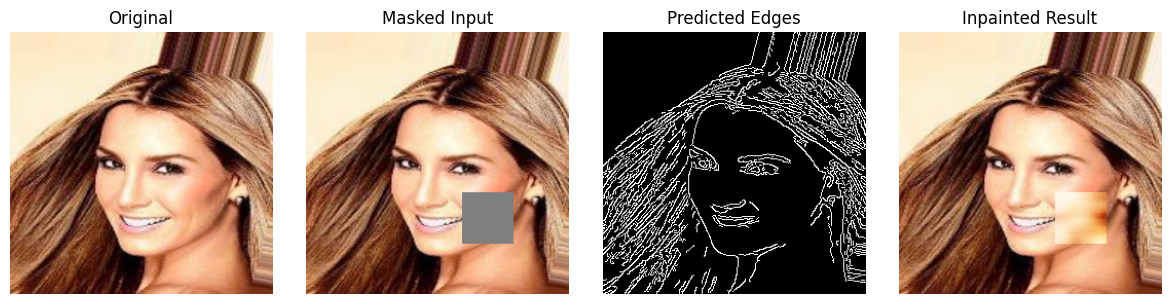

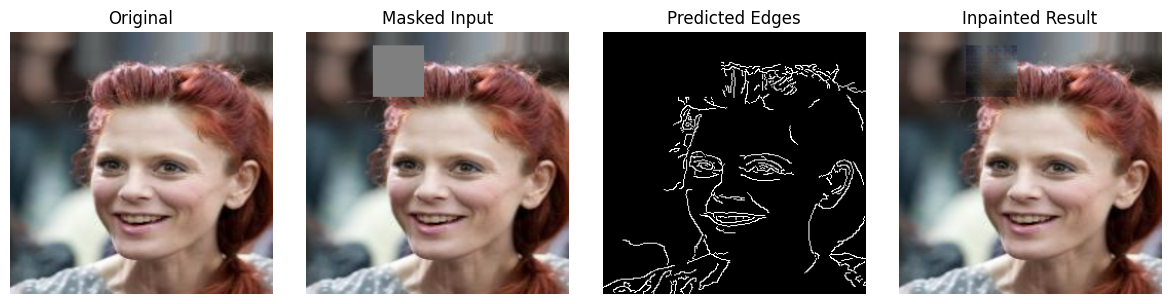

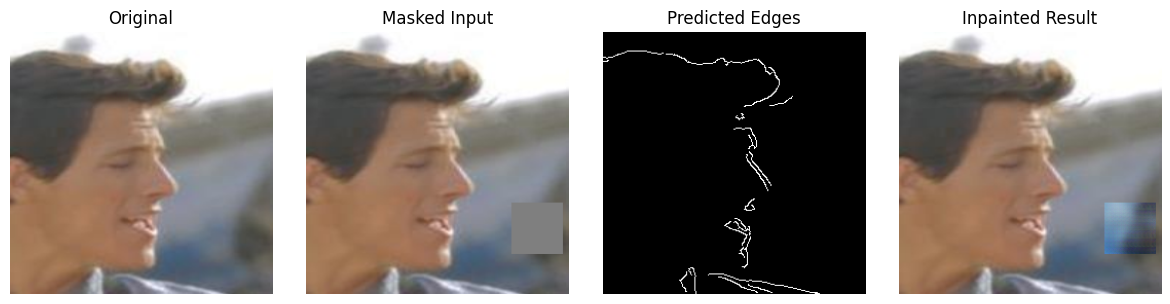

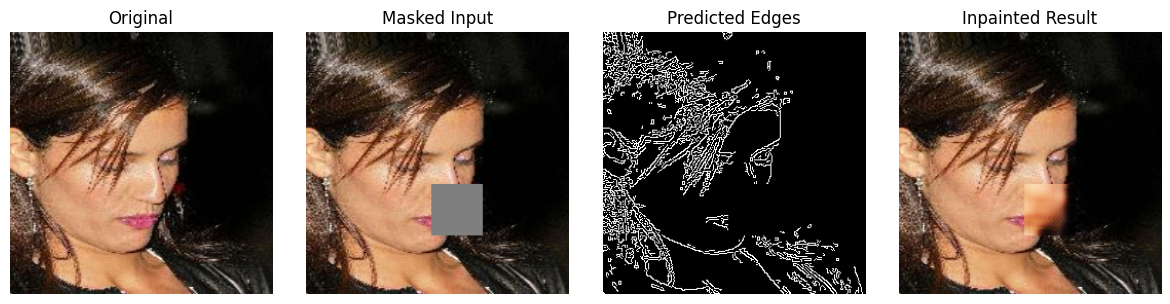

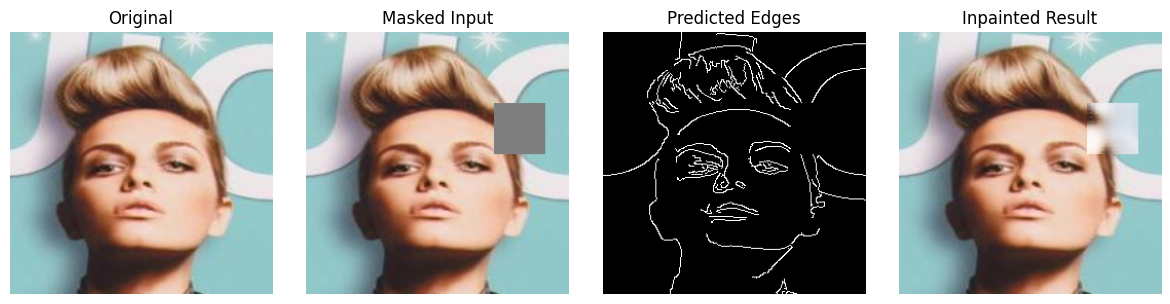

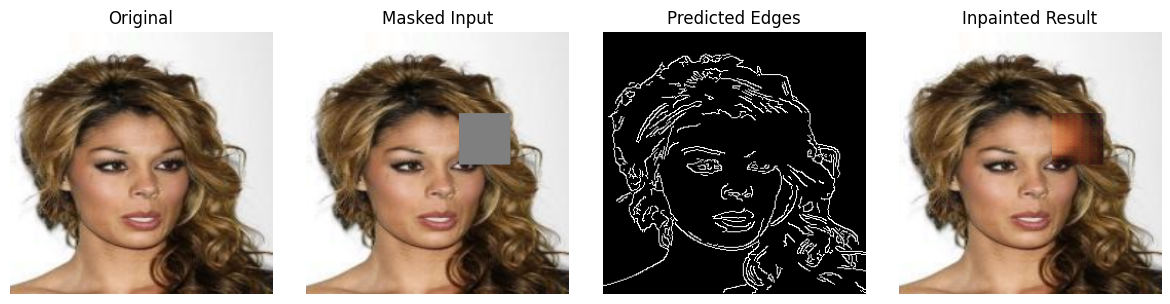

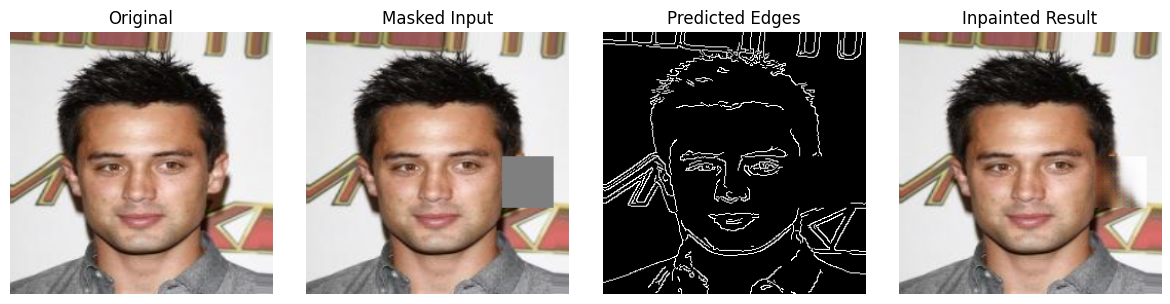

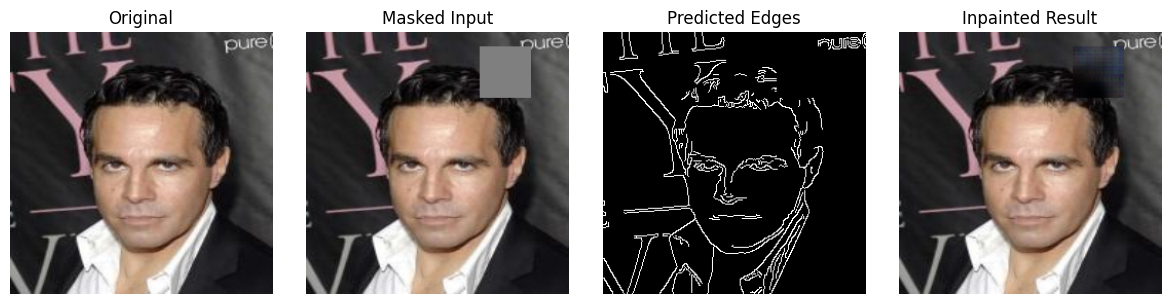

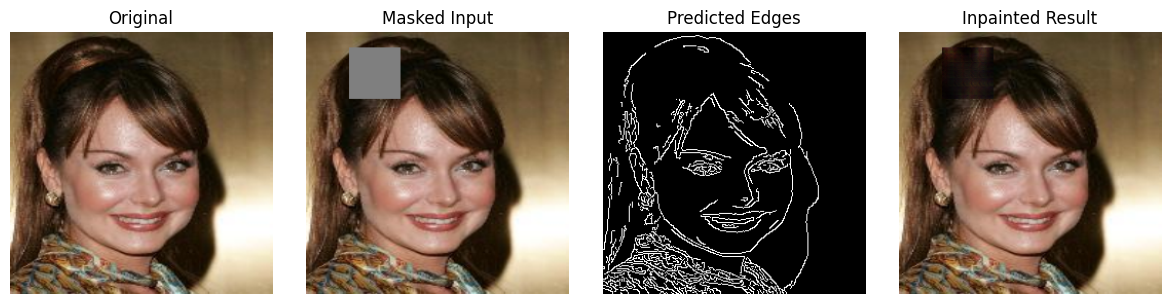

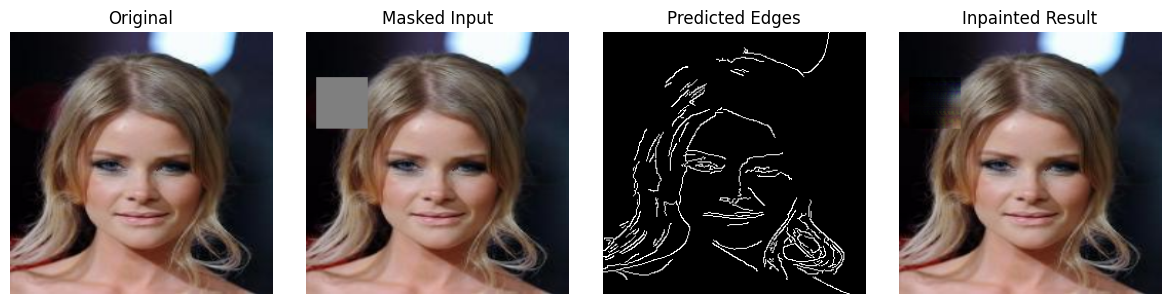

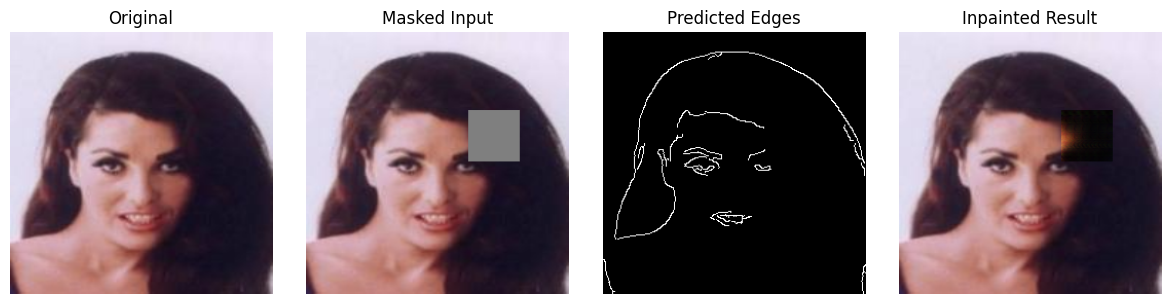

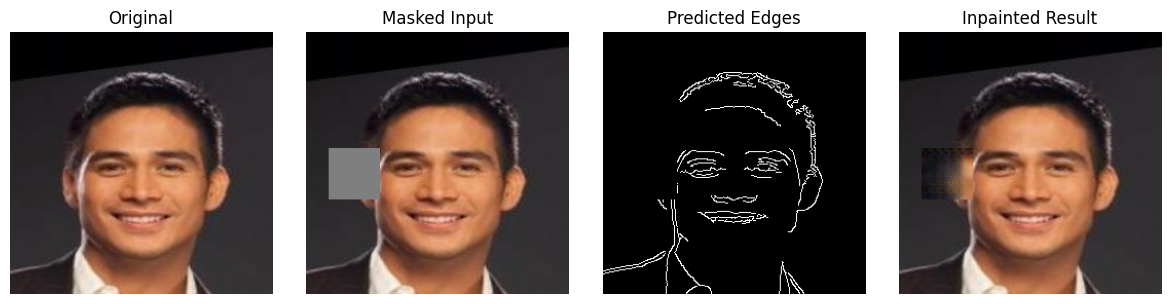

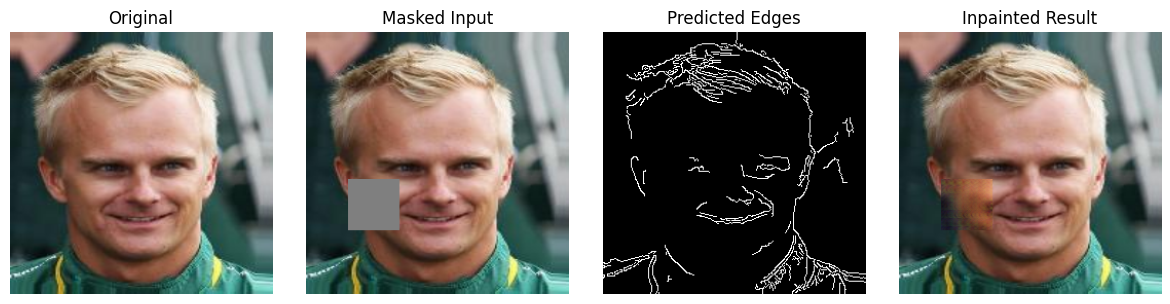

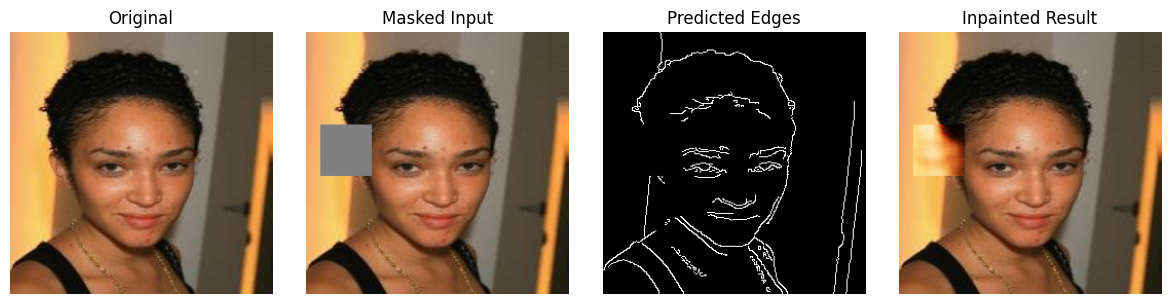

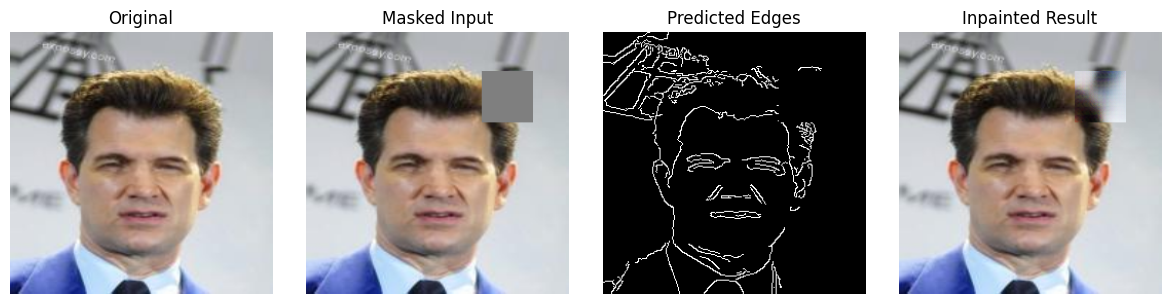

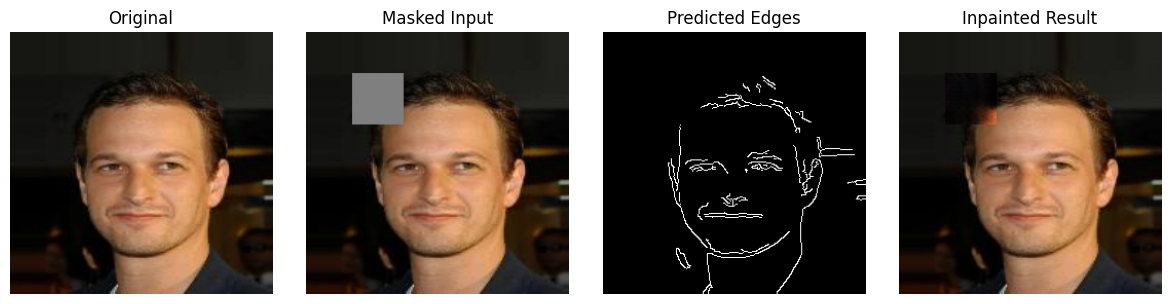

In [ ]:
def inpaint_image(image_path, mask_size=50, custom_mask=None):
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    if custom_mask is None:
        mask = torch.ones_like(image_tensor)
        x = np.random.randint(0, 256 - mask_size)
        y = np.random.randint(0, 256 - mask_size)
        mask[:, :, x:x+mask_size, y:y+mask_size] = 0
    else:
        mask = custom_mask.to(device)
    masked_image = image_tensor * mask
    grayscale = to_grayscale(image_tensor)
    real_edges = detect_edges(image_tensor).to(device)
    masked_edges = real_edges * mask[:,0:1,:,:]
    edge_generator_mask = mask[:,0:1,:,:]  # single-channel mask
    with torch.no_grad():
        fake_edges = edge_generator(grayscale, masked_edges, edge_generator_mask)
        composite_edges = masked_edges + fake_edges * (1 - mask[:,0:1,:,:])
        fake_image = image_generator(masked_image, composite_edges, mask)
    result = masked_image + fake_image * (1 - mask)
    def denormalize(img):
        return (img * 0.5) + 0.5
    original = (denormalize(image_tensor[0]).cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
    masked = (denormalize(masked_image[0]).cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
    result_img = (denormalize(result[0]).cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
    edges = (composite_edges[0].cpu().numpy()[0] * 255).astype(np.uint8)
    return {'original': original, 'masked': masked, 'result': result_img, 'edges': edges}

def test_model(test_image_path, mask_size=50):
    result_dict = inpaint_image(test_image_path, mask_size)
    plt.figure(figsize=(12,3))
    plt.subplot(1,4,1)
    plt.imshow(result_dict['original'])
    plt.title('Original')
    plt.axis("off")
    plt.subplot(1,4,2)
    plt.imshow(result_dict['masked'])
    plt.title('Masked Input')
    plt.axis("off")
    plt.subplot(1,4,3)
    plt.imshow(result_dict['edges'], cmap='gray')
    plt.title('Predicted Edges')
    plt.axis("off")
    plt.subplot(1,4,4)
    plt.imshow(result_dict['result'])
    plt.title('Inpainted Result')
    plt.axis("off")
    plt.tight_layout()
    # plt.savefig('test_result.png')
    plt.show()
    return result_dict

test_model("images_dl/000001.jpg");
test_model("images_dl/000002.jpg");
test_model("images_dl/000003.jpg");
test_model("images_dl/000004.jpg");
test_model("images_dl/000005.jpg");
test_model("images_dl/000006.jpg");
test_model("images_dl/000007.jpg");
test_model("images_dl/000008.jpg");
test_model("images_dl/000009.jpg");
test_model("images_dl/000010.jpg");
test_model("images_dl/000011.jpg");
test_model("images_dl/000012.jpg");
test_model("images_dl/000013.jpg");
test_model("images_dl/000014.jpg");
test_model("images_dl/000015.jpg");
test_model("images_dl/000016.jpg");

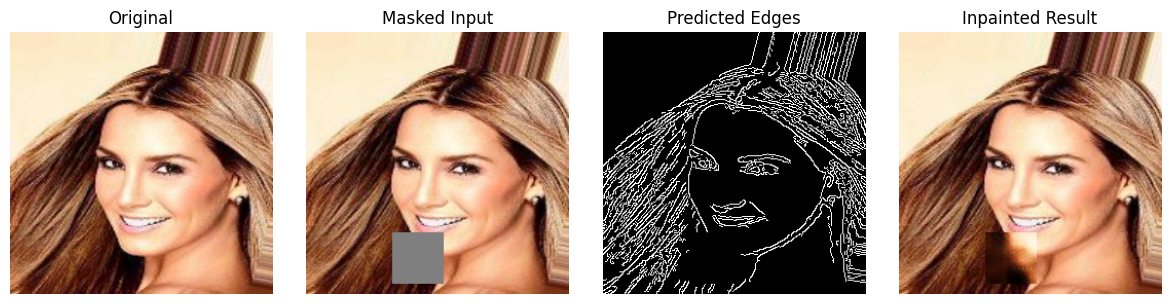

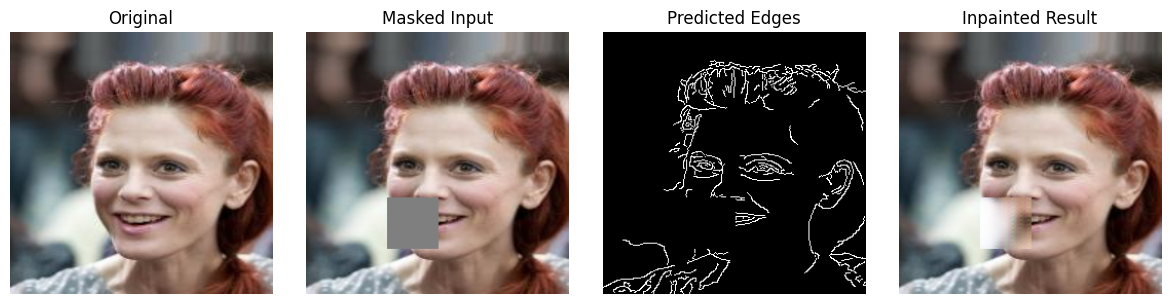

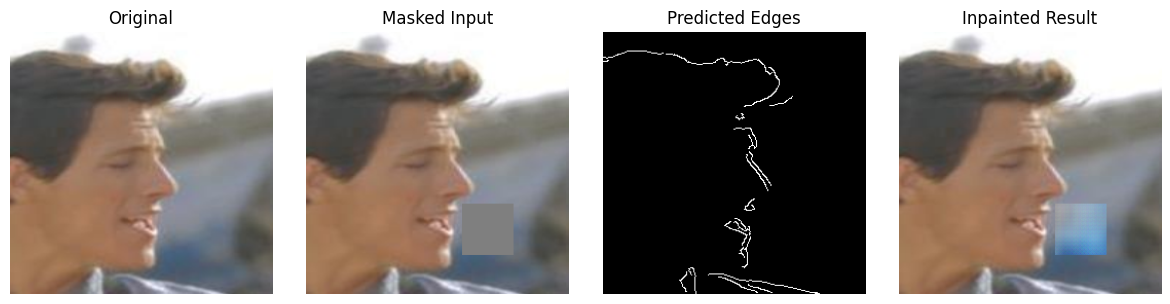

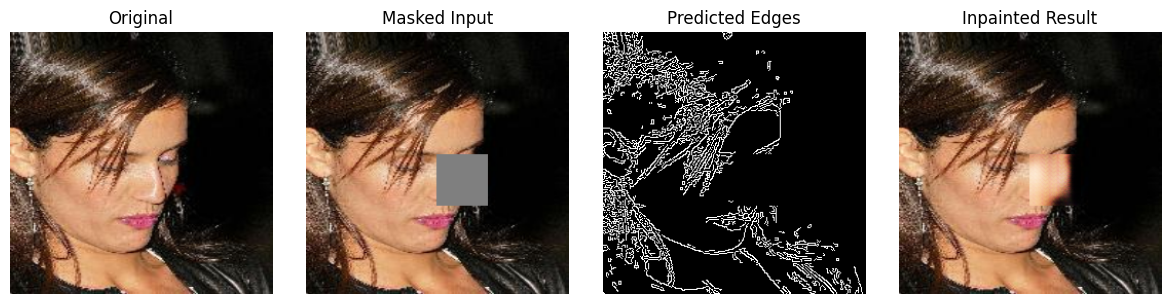

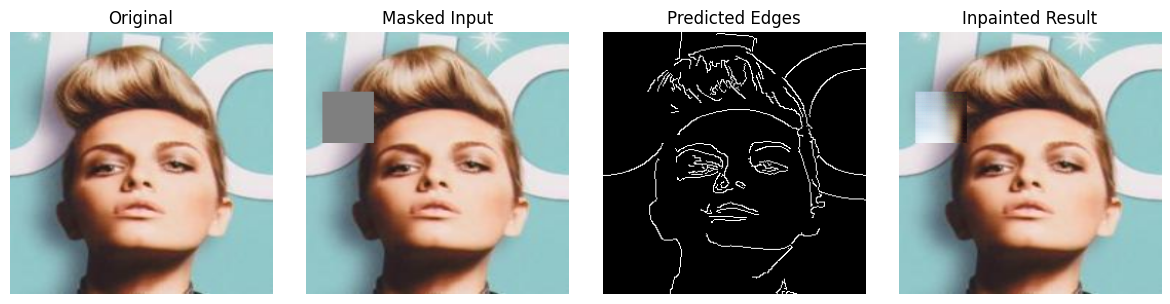

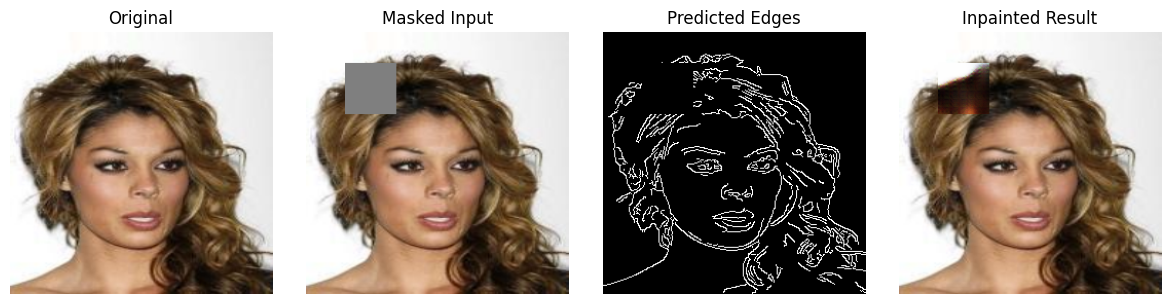

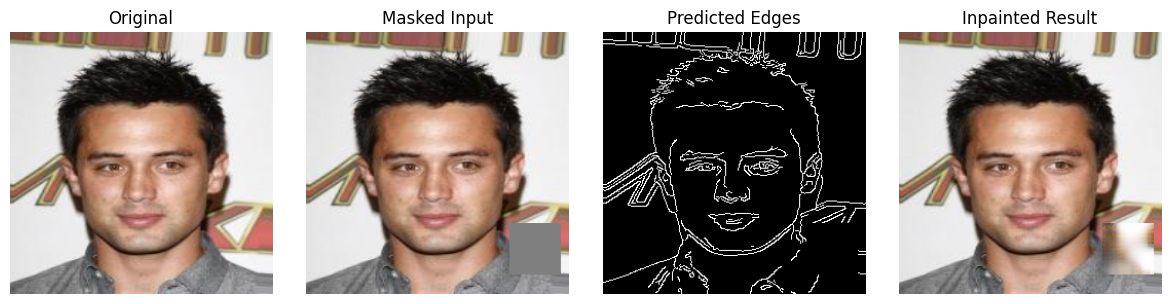

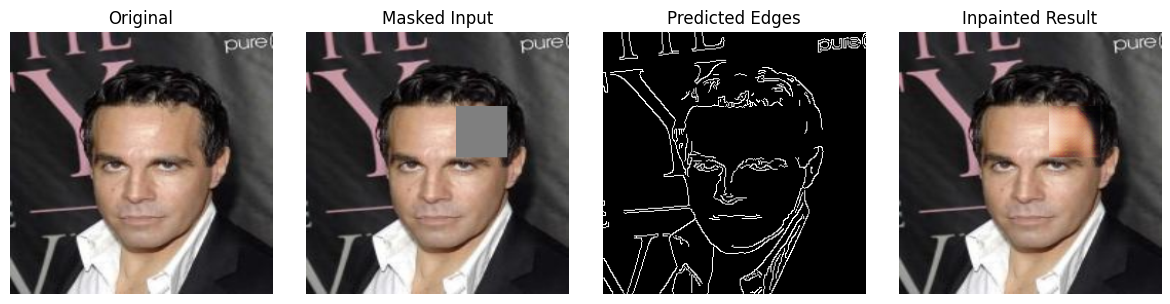

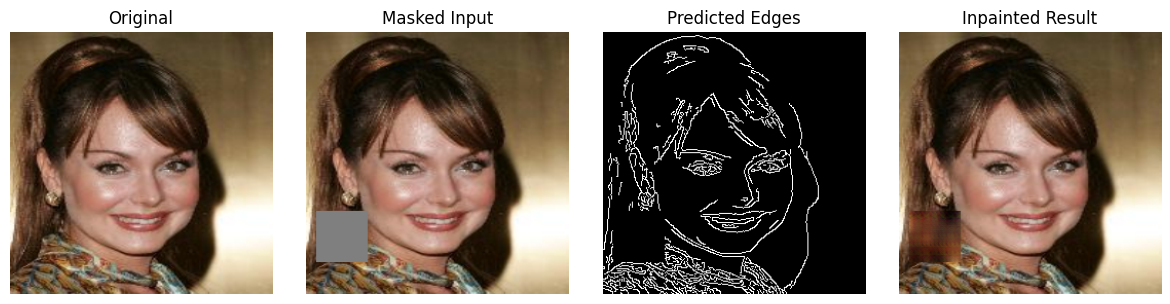

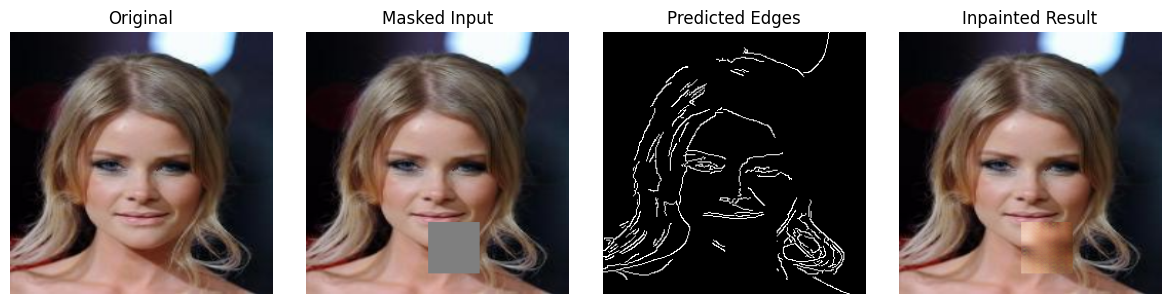

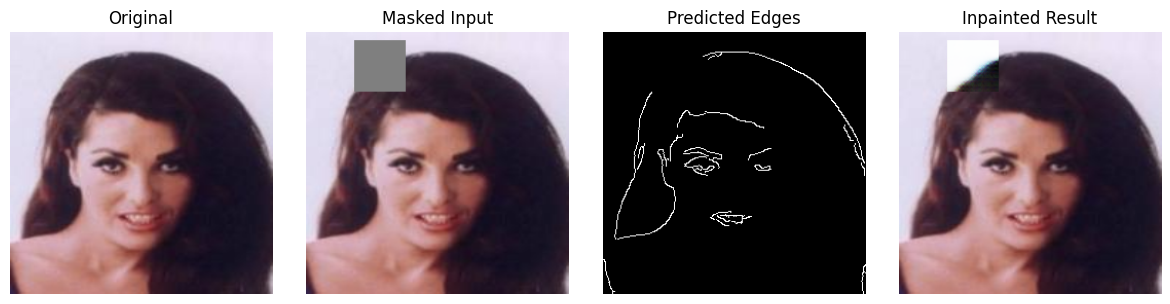

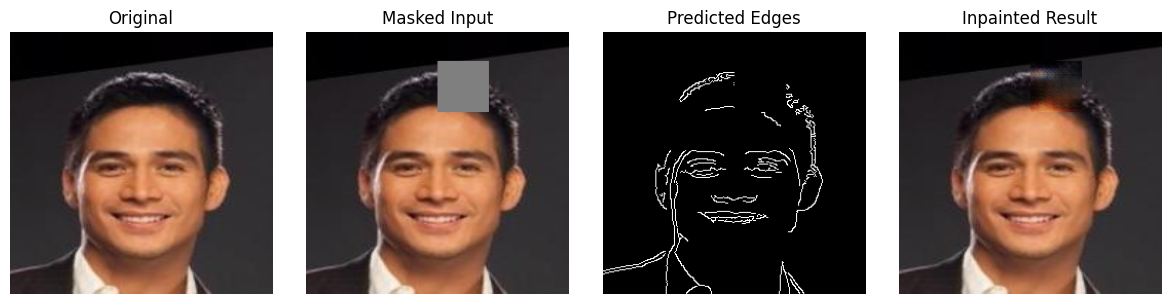

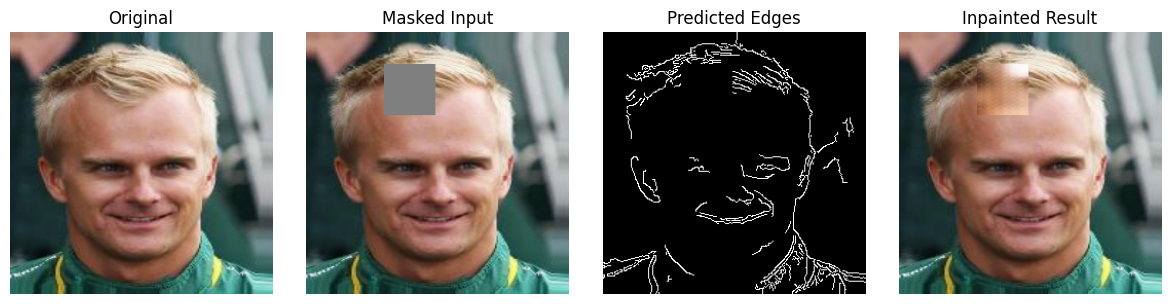

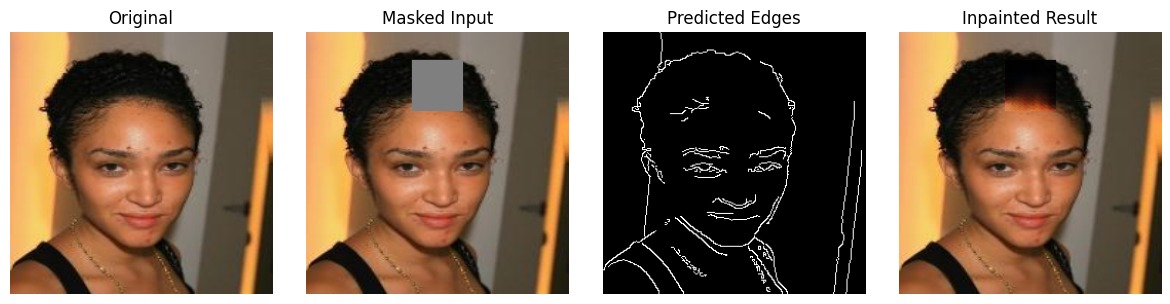

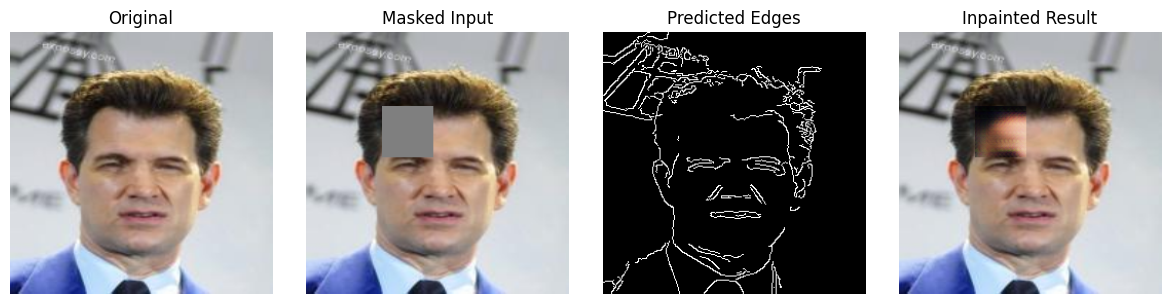

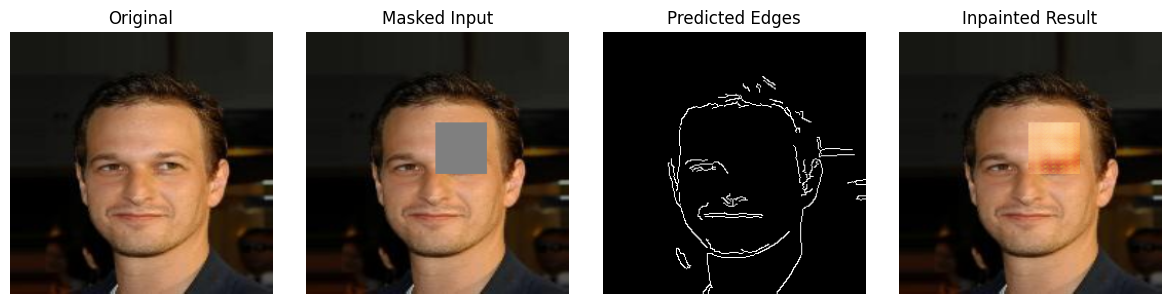

In [ ]:
def inpaint_image(image_path, mask_size=50, custom_mask=None):
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    if custom_mask is None:
        mask = torch.ones_like(image_tensor)
        x = np.random.randint(0, 256 - mask_size)
        y = np.random.randint(0, 256 - mask_size)
        mask[:, :, x:x+mask_size, y:y+mask_size] = 0
    else:
        mask = custom_mask.to(device)
    masked_image = image_tensor * mask
    grayscale = to_grayscale(image_tensor)
    real_edges = detect_edges(image_tensor).to(device)
    masked_edges = real_edges * mask[:,0:1,:,:]
    edge_generator_mask = mask[:,0:1,:,:]  # single-channel mask
    with torch.no_grad():
        fake_edges = edge_generator(grayscale, masked_edges, edge_generator_mask)
        composite_edges = masked_edges + fake_edges * (1 - mask[:,0:1,:,:])
        fake_image = image_generator(masked_image, composite_edges, mask)
    result = masked_image + fake_image * (1 - mask)
    def denormalize(img):
        return (img * 0.5) + 0.5
    original = (denormalize(image_tensor[0]).cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
    masked = (denormalize(masked_image[0]).cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
    result_img = (denormalize(result[0]).cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
    edges = (composite_edges[0].cpu().numpy()[0] * 255).astype(np.uint8)
    return {'original': original, 'masked': masked, 'result': result_img, 'edges': edges}

def test_model(test_image_path, mask_size=50):
    result_dict = inpaint_image(test_image_path, mask_size)
    plt.figure(figsize=(12,3))
    plt.subplot(1,4,1)
    plt.imshow(result_dict['original'])
    plt.title('Original')
    plt.axis("off")
    plt.subplot(1,4,2)
    plt.imshow(result_dict['masked'])
    plt.title('Masked Input')
    plt.axis("off")
    plt.subplot(1,4,3)
    plt.imshow(result_dict['edges'], cmap='gray')
    plt.title('Predicted Edges')
    plt.axis("off")
    plt.subplot(1,4,4)
    plt.imshow(result_dict['result'])
    plt.title('Inpainted Result')
    plt.axis("off")
    plt.tight_layout()
    # plt.savefig('test_result.png')
    plt.show()
    return result_dict

test_model("images_dl/000001.jpg");
test_model("images_dl/000002.jpg");
test_model("images_dl/000003.jpg");
test_model("images_dl/000004.jpg");
test_model("images_dl/000005.jpg");
test_model("images_dl/000006.jpg");
test_model("images_dl/000007.jpg");
test_model("images_dl/000008.jpg");
test_model("images_dl/000009.jpg");
test_model("images_dl/000010.jpg");
test_model("images_dl/000011.jpg");
test_model("images_dl/000012.jpg");
test_model("images_dl/000013.jpg");
test_model("images_dl/000014.jpg");
test_model("images_dl/000015.jpg");
test_model("images_dl/000016.jpg");

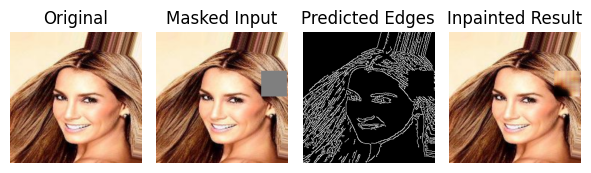

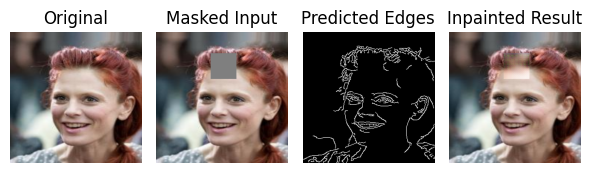

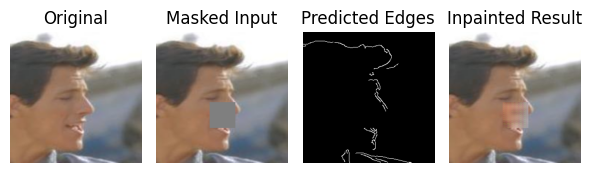

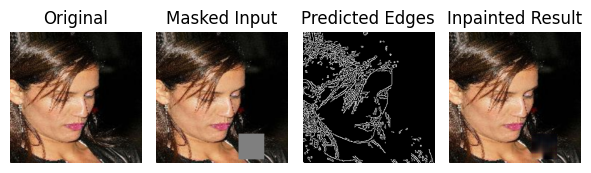

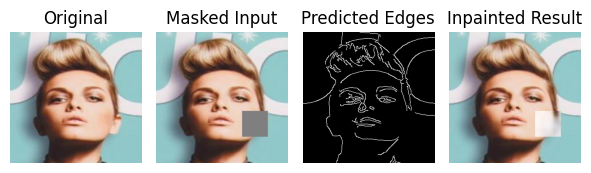

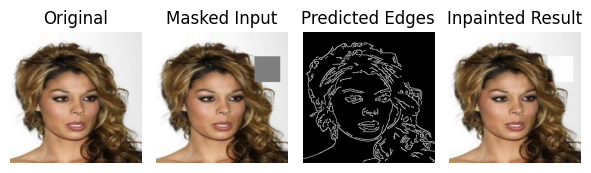

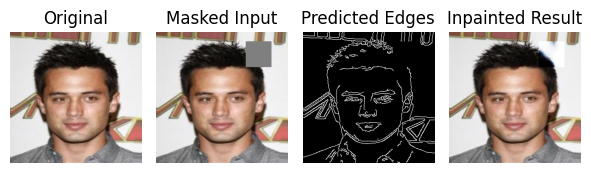

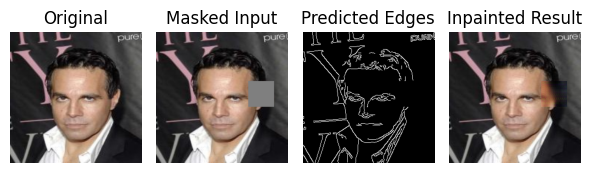

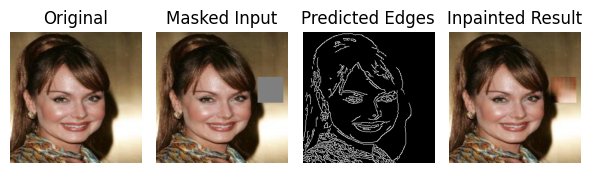

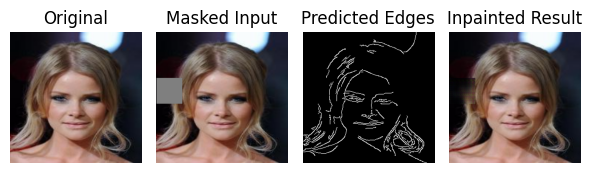

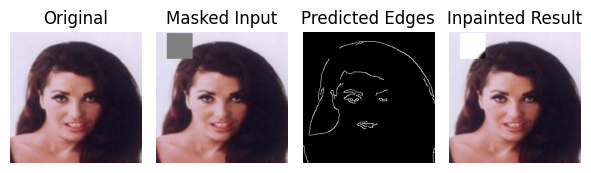

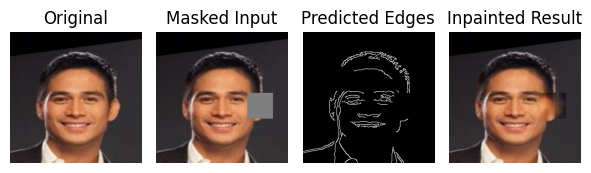

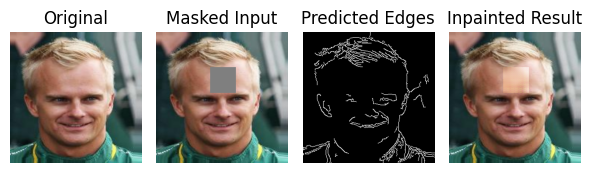

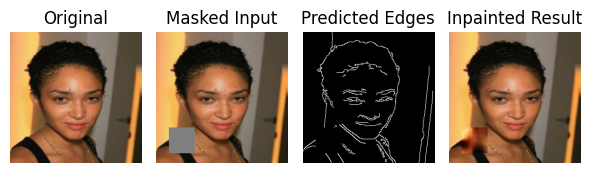

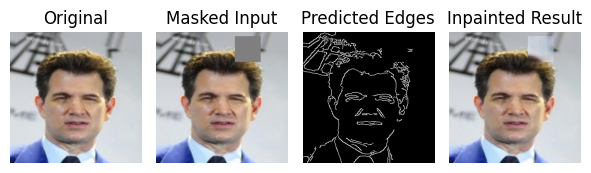

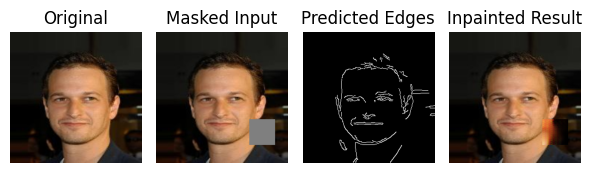

In [ ]:
def inpaint_image(image_path, mask_size=50, custom_mask=None):
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    if custom_mask is None:
        mask = torch.ones_like(image_tensor)
        x = np.random.randint(0, 256 - mask_size)
        y = np.random.randint(0, 256 - mask_size)
        mask[:, :, x:x+mask_size, y:y+mask_size] = 0
    else:
        mask = custom_mask.to(device)
    masked_image = image_tensor * mask
    grayscale = to_grayscale(image_tensor)
    real_edges = detect_edges(image_tensor).to(device)
    masked_edges = real_edges * mask[:,0:1,:,:]
    edge_generator_mask = mask[:,0:1,:,:]  # single-channel mask
    with torch.no_grad():
        fake_edges = edge_generator(grayscale, masked_edges, edge_generator_mask)
        composite_edges = masked_edges + fake_edges * (1 - mask[:,0:1,:,:])
        fake_image = image_generator(masked_image, composite_edges, mask)
    result = masked_image + fake_image * (1 - mask)
    def denormalize(img):
        return (img * 0.5) + 0.5
    original = (denormalize(image_tensor[0]).cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
    masked = (denormalize(masked_image[0]).cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
    result_img = (denormalize(result[0]).cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
    edges = (composite_edges[0].cpu().numpy()[0] * 255).astype(np.uint8)
    return {'original': original, 'masked': masked, 'result': result_img, 'edges': edges}

def test_model(test_image_path, mask_size=50):
    result_dict = inpaint_image(test_image_path, mask_size)
    plt.figure(figsize=(6,3))
    plt.subplot(1,4,1)
    plt.imshow(result_dict['original'])
    plt.title('Original')
    plt.axis("off")
    plt.subplot(1,4,2)
    plt.imshow(result_dict['masked'])
    plt.title('Masked Input')
    plt.axis("off")
    plt.subplot(1,4,3)
    plt.imshow(result_dict['edges'], cmap='gray')
    plt.title('Predicted Edges')
    plt.axis("off")
    plt.subplot(1,4,4)
    plt.imshow(result_dict['result'])
    plt.title('Inpainted Result')
    plt.axis("off")
    plt.tight_layout()
    # plt.savefig('test_result.png')
    plt.show()
    return result_dict

test_model("images_dl/000001.jpg");
test_model("images_dl/000002.jpg");
test_model("images_dl/000003.jpg");
test_model("images_dl/000004.jpg");
test_model("images_dl/000005.jpg");
test_model("images_dl/000006.jpg");
test_model("images_dl/000007.jpg");
test_model("images_dl/000008.jpg");
test_model("images_dl/000009.jpg");
test_model("images_dl/000010.jpg");
test_model("images_dl/000011.jpg");
test_model("images_dl/000012.jpg");
test_model("images_dl/000013.jpg");
test_model("images_dl/000014.jpg");
test_model("images_dl/000015.jpg");
test_model("images_dl/000016.jpg");

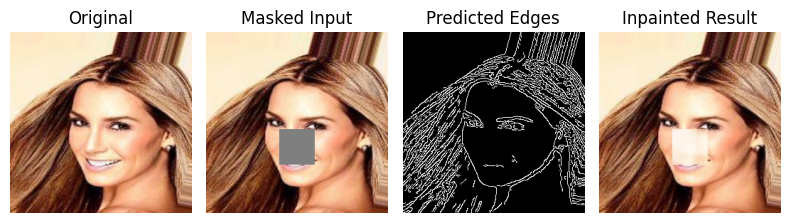

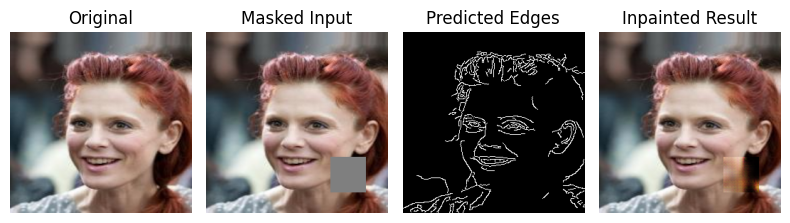

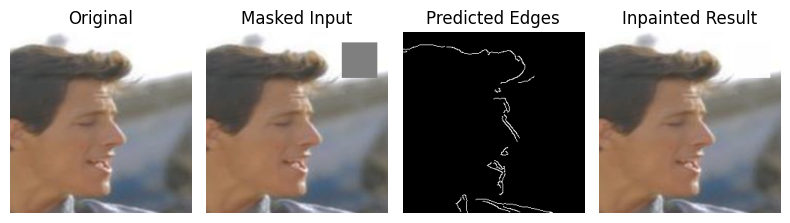

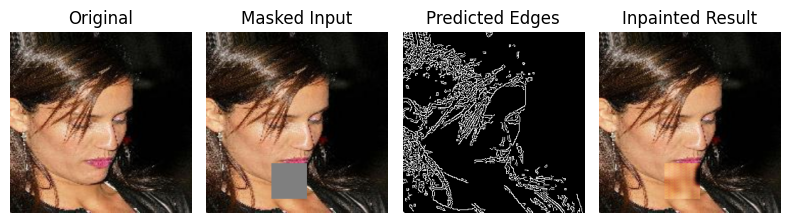

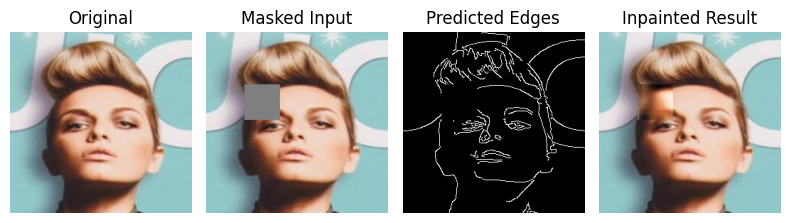

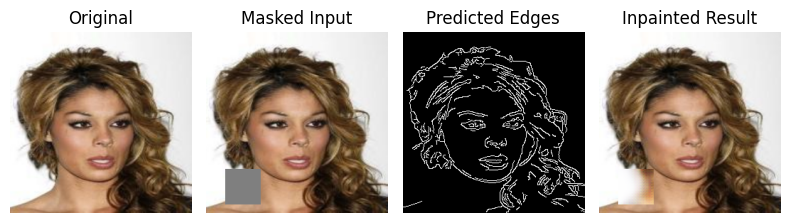

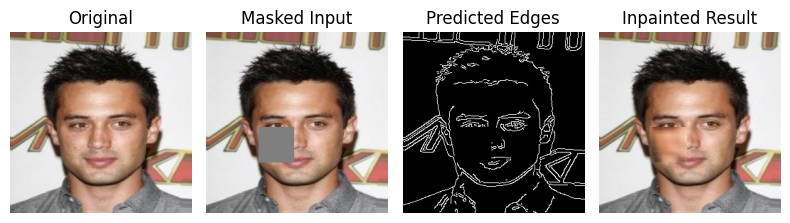

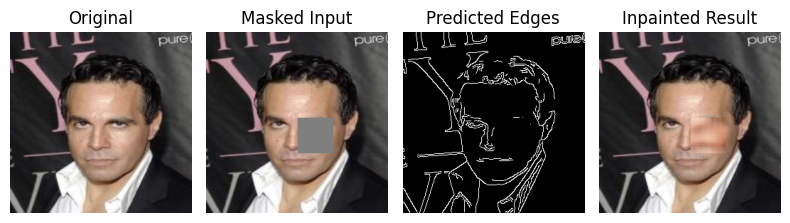

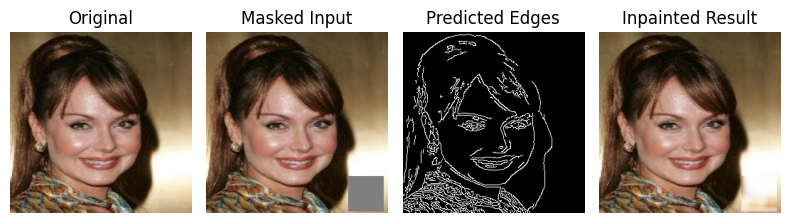

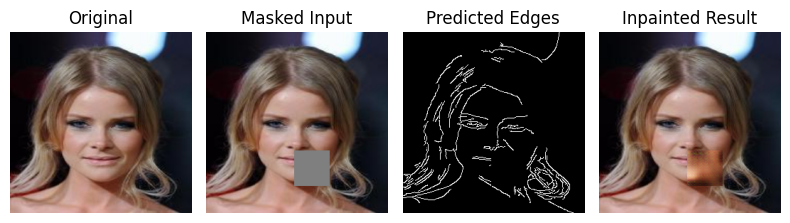

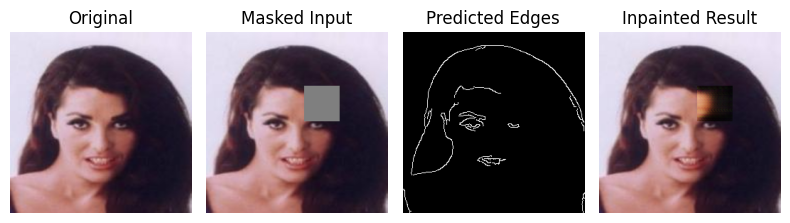

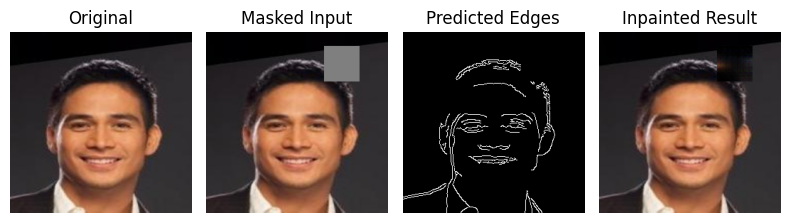

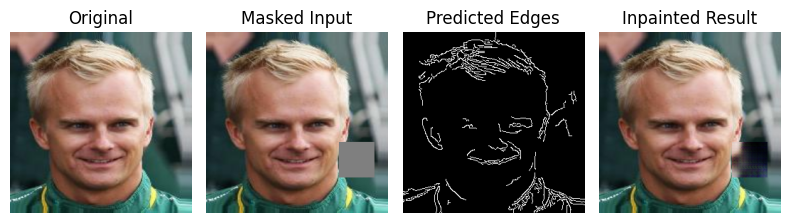

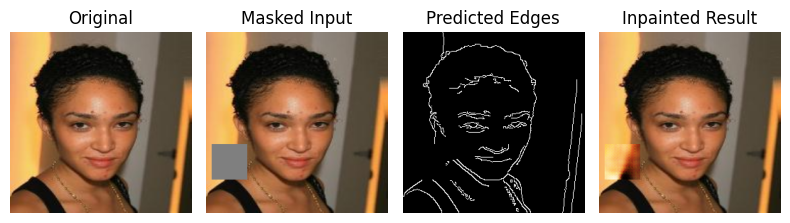

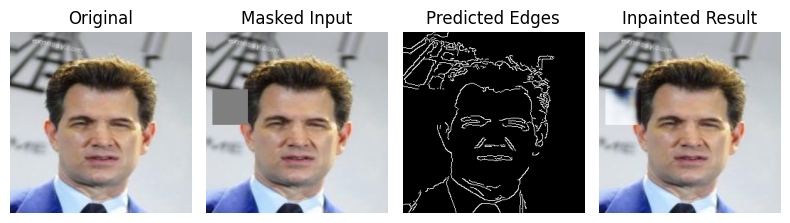

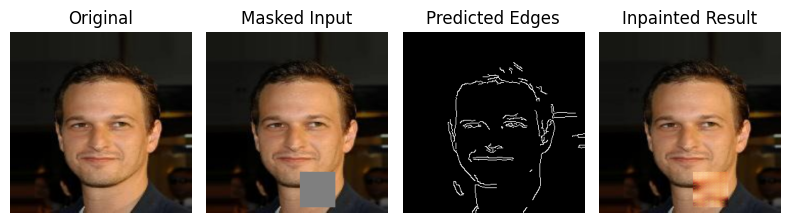

In [ ]:
def inpaint_image(image_path, mask_size=50, custom_mask=None):
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    if custom_mask is None:
        mask = torch.ones_like(image_tensor)
        x = np.random.randint(0, 256 - mask_size)
        y = np.random.randint(0, 256 - mask_size)
        mask[:, :, x:x+mask_size, y:y+mask_size] = 0
    else:
        mask = custom_mask.to(device)
    masked_image = image_tensor * mask
    grayscale = to_grayscale(image_tensor)
    real_edges = detect_edges(image_tensor).to(device)
    masked_edges = real_edges * mask[:,0:1,:,:]
    edge_generator_mask = mask[:,0:1,:,:]  # single-channel mask
    with torch.no_grad():
        fake_edges = edge_generator(grayscale, masked_edges, edge_generator_mask)
        composite_edges = masked_edges + fake_edges * (1 - mask[:,0:1,:,:])
        fake_image = image_generator(masked_image, composite_edges, mask)
    result = masked_image + fake_image * (1 - mask)
    def denormalize(img):
        return (img * 0.5) + 0.5
    original = (denormalize(image_tensor[0]).cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
    masked = (denormalize(masked_image[0]).cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
    result_img = (denormalize(result[0]).cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
    edges = (composite_edges[0].cpu().numpy()[0] * 255).astype(np.uint8)
    return {'original': original, 'masked': masked, 'result': result_img, 'edges': edges}

def test_model(test_image_path, mask_size=50):
    result_dict = inpaint_image(test_image_path, mask_size)
    plt.figure(figsize=(8,3))
    plt.subplot(1,4,1)
    plt.imshow(result_dict['original'])
    plt.title('Original')
    plt.axis("off")
    plt.subplot(1,4,2)
    plt.imshow(result_dict['masked'])
    plt.title('Masked Input')
    plt.axis("off")
    plt.subplot(1,4,3)
    plt.imshow(result_dict['edges'], cmap='gray')
    plt.title('Predicted Edges')
    plt.axis("off")
    plt.subplot(1,4,4)
    plt.imshow(result_dict['result'])
    plt.title('Inpainted Result')
    plt.axis("off")
    plt.tight_layout()
    # plt.savefig('test_result.png')
    plt.show()
    return result_dict

test_model("images_dl/000001.jpg");
test_model("images_dl/000002.jpg");
test_model("images_dl/000003.jpg");
test_model("images_dl/000004.jpg");
test_model("images_dl/000005.jpg");
test_model("images_dl/000006.jpg");
test_model("images_dl/000007.jpg");
test_model("images_dl/000008.jpg");
test_model("images_dl/000009.jpg");
test_model("images_dl/000010.jpg");
test_model("images_dl/000011.jpg");
test_model("images_dl/000012.jpg");
test_model("images_dl/000013.jpg");
test_model("images_dl/000014.jpg");
test_model("images_dl/000015.jpg");
test_model("images_dl/000016.jpg");